<a href="https://colab.research.google.com/github/looee1q/PracticalML/blob/9-decision-tree/Trees_final_task_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решающие деревья. Практика

В этом задании будем решать задачу классификации клиентов телекома: для каждого клиента необходимо определить, перестанет он пользоваться услугами оператора (оттоковый клиент) в ближайшее время или нет.

В ноутбуке будем использовать несколько моделей, в том числе SVM, поэтому установим библиотеку для быстрого обучения SVM.

## Импорт библиотек и загрузка данных

In [1]:
# убедимся, что версия python < 3.10
!python --version

Python 3.11.12


In [2]:
%%capture
!python -m pip install --upgrade pip
!pip install --upgrade scikit-learn-intelex

In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [4]:
import sys
import os
import site
import pandas as pd
import numpy as np

sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [29]:
# зафиксируем константы
RANDOM_STATE = 42

In [30]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/telecom_churn.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Практика

In [31]:
np.random.seed(RANDOM_STATE)

Сделайте первичную обработку данных:

1) Выбросите колонку State

2) Колонки International plan и Voice mail plan закодируйте следующим образом: "Yes" замените на 1, а "No" на 0.

3) Переведите целевую переменную (Churn) в числа: True в 1, а False в 0.

In [32]:
df.drop(columns=['State'], inplace=True)
df[['International plan', 'Voice mail plan']] = df[['International plan', 'Voice mail plan']].replace({"Yes" : 1, "No" : 0})
df["Churn"] = df["Churn"].map({True : 1, False : 0})

<ipython-input-32-e3214dbfc14a>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['International plan', 'Voice mail plan']] = df[['International plan', 'Voice mail plan']].replace({"Yes" : 1, "No" : 0})


In [33]:
df.shape

(3333, 19)

### Вопрос

Чему равна сумма значений в закодированном столбце International plan?

In [34]:
df['International plan'].sum()

np.int64(323)

Выведите на экран первые строки измененной таблицы, чтобы проверить, что все преобразования сработали.

In [35]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Создайте матрицу объект-признак X и вектор с целевой переменной (Churn) y.

In [36]:
X = df.drop("Churn", axis=1)
y = df['Churn'].copy()

### Вопрос

Проверьте баланс классов. Является ли выборка сбалансированной?

In [37]:
y.value_counts()

,count
Churn,
0,2850
1,483


По кросс-валидации с тремя фолдами и метрикой ROC-AUC (scoring='roc_auc') обучите:

1) Логистическую регрессию

2) Метод опорных векторов (с kernel='linear')

Выведите на экран среднее качество моделей на кросс-валидации.

При объявлении SVC не забудьте указать в гиперпараметрах probability = True (так как метод изначально не предсказывает вероятности классов, а они нам нужны для вычисления ROC-AUC).

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

model_log_reg = LogisticRegression(max_iter=10000)
model_svc = SVC(kernel='linear', probability=True)

In [45]:
log_reg_roc_auc_mean = cross_val_score(
    estimator = model_log_reg,
    X = X,
    y = y,
    cv = 3,
    scoring = 'roc_auc'
).mean()

/usr/local/lib/python3.11/dist-packages/daal4py/sklearn/linear_model/logistic_path.py:628: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/daal4py/sklearn/linear_model/logistic_path.py:628: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [46]:
log_reg_roc_auc_mean

np.float64(0.8111125640187424)

In [ ]:
svc_roc_auc_mean = cross_val_score(
    estimator = model_svc,
    X = X,
    y = y,
    cv = 3,
    scoring = 'roc_auc'
).mean()

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [ ]:
svc_roc_auc_mean

Теперь обучите решающее дерево с параметрами по умолчанию по кросс-валидации с тремя фолдами и той же метрикой.

ВАЖНО! У решающего дерева для воспроизводимости результатов фиксируйте random_state = RANDOM_STATE

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [ ]:
tree_roc_auc = cross_val_score(
    estimator = tree,
    X = X,
    y = y,
    cv = 3,
    scoring = 'roc_auc'
)

In [ ]:
tree_roc_auc.mean()

### Вопрос

Какой из трех алгоритмов показал наилучшее качество на кросс-валидации?

Ваша цель - максимально улучшить модели. Для этого:

1) у линейных моделей подберите гиперпараметр С (переберите 20 значений C в диапазоне от 0.1 до 10 с равным шагом).

2) у решающего дерева подберите max_depth (переберите глубину от 1 до 10 с шагом 1) и criterion - "gini" или "entropy".

Для подбора параметров используйте GridSearchCV с тремя фолдами и метрикой roc-auc или обычные циклы.

Подбор параметров осуществляется только по тренировочным данным!

При подборе гиперпараметров по кросс-валидации для дальнейшей корректной оценки качества модели нужна отдельная выборка. Давайте сразу действовать правильно:

1) сначала разбиваем (как и раньше) данные на тренировочную и тестовую части
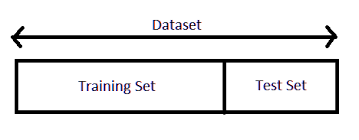

2) затем по тренировочной части при помощи GridSearchCV подбираем оптимальные значения гиперпараметров

3) наконец, делаем предсказание модели с оптимальными гиперпараметрами на тестовых данных и уже по ним оцениваем итоговую метрику.

Сложно, зато правильно!

Первую модель обучим для примера. Дальше вы сами.

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'C' : np.linspace(0.1, 10.01, 20)}

gs_log_reg = GridSearchCV(LogisticRegression(), params, cv=3, scoring='roc_auc')

gs_log_reg.fit(Xtrain, ytrain)

gs_log_reg.best_score_, gs_log_reg.best_estimator_

In [ ]:
from sklearn.metrics import roc_auc_score

lr = gs_log_reg.best_estimator_

pred_lr = lr.predict_proba(Xtest)[:,1]
print(roc_auc_score(ytest, pred_lr))

In [ ]:
params = {""  }
gs_tree = GridSearchCV()

### Вопрос

Чему равно качество решающего дерева с подобранными гиперпараметрами, посчитанное на тестовой выборке?

Ответ округлите до сотых.

Какая модель справилась с решением задачи лучше всего по метрике roc_auc?

Нарисуйте roc-кривую для наилучшей модели.

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

# your code here

Сравните между собой две лучшие модели.

### Вопрос

Насколько сильно отличается качество предсказания на тестовых данных?
(вычислите разность значений roc-auc)

In [ ]:
# your code here

Постройте гистограммы важности признаков (для линейных моделей берите модуль значений весов) для каждой из этих моделей. Сравните между собой списки из трех самых важных признаков. Совпадают ли они?

### Вопрос

Какой признак наиболее важен для решающего дерева?

In [ ]:
# your code here

Сделайте выводы (для себя)

1) Являются ли данные сбалансированными? Что это означает?

2) Какая модель после подбора гиперпараметров лучше всего решает задачу с точки зрения метрики roc-auc?

3) Одинаковые ли признаки важны для работы двух наилучших моделей? Как вы думаете, почему так?